## Import librarys and Data

In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from pickle import load

#import tensorflow library
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow import keras 
from tensorflow.keras.optimizers import Adam
#import sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from pickle import dump
from pickle import load
from keras.models import load_model
from sklearn.linear_model import LinearRegression

### Load data

The engines operate normally in the beginning but develop a fault over time. For the training sets, the engines are run to failure, while in the test sets the time series end ‘sometime’ before failure.

The goal is to predict the Remaining Useful Life (RUL) of each turbofan engine.

In [17]:
#set the path 
%cd /content/drive/My Drive/Self Case Study 1/data/output/FD001

/content/drive/My Drive/Self Case Study 1/data/output/FD001


we are selecting some features as fer feature selection

In [18]:
imp_col = ['RUL','Engine_No','T50','Nf','Ps30','phi','NRf','NRc','BPR','W31','W32','T48','T41','T90','Ve','EGT_margin','Nc/Nf','PCNcRdmd ','M_cold','W_f','Thrust','Fan_thrust','core_thrust','TSFC','Thermal_efficiency']

In [19]:
Train= pd.read_csv('Feature_Engg_Train_F0001.csv', usecols =imp_col) 
Test = pd.read_csv('Feature_Engg_Test_F0001.csv',  usecols =imp_col) 

In [20]:
Test.head()

,Engine_No,T50,Nf,Ps30,phi,NRf,NRc,BPR,W31,W32,RUL,T48,T41,T90,Ve,EGT_margin,Nc/Nf,PCNcRdmd,M_cold,W_f,Thrust,Fan_thrust,core_thrust,TSFC,Thermal_efficiency
0,1,776.783955,2388.04,3.254327,521.72,2388.03,8125.55,8.4052,38.86,23.3735,142,1354.757660,1820.418395,731.150670,323.547145,491.999330,3.789790,0.736134,59.936127,67.707692,23165.746033,20790.096502,2375.649531,9.234547,44.433614
1,1,775.233954,2388.01,3.275011,522.16,2388.06,8139.62,8.3803,39.02,23.3916,141,1345.604783,1813.474550,729.722702,323.114237,493.427298,3.791617,0.736255,60.189109,67.993477,23259.330008,20868.300945,2391.029063,9.263656,44.219538
2,1,778.522845,2388.05,3.275011,521.97,2388.03,8130.10,8.4441,39.08,23.4166,140,1356.273432,1823.026329,732.799850,323.865020,490.350150,3.792617,0.736332,60.625266,68.486188,23418.557067,21023.823195,2394.733872,9.197322,44.591665
3,1,781.345070,2388.03,3.259843,521.38,2388.05,8132.90,8.3917,39.00,23.3737,139,1355.797218,1821.166381,735.431972,324.537588,487.718028,3.787762,0.735990,59.902221,67.669390,23160.969535,20774.833481,2386.136054,9.246077,44.358269
4,1,778.845068,2388.01,3.261911,522.15,2388.03,8129.54,8.4031,38.99,23.4130,138,1354.319792,1821.171527,733.096301,323.956277,490.053699,3.787484,0.735970,60.110301,67.904450,23235.048021,20848.154792,2386.893229,9.236066,44.401723


### standardization

Sklearns’ MinMaxScaler can be used to create a scaler fitted to our train data. The default settings create a scaler to scale our training features between 0–1. The scaler is then applied to both our X_train and X_test set.

In [21]:
min_max= MinMaxScaler()
cols = Train.columns.difference(['RUL','Engine_No']) 
norm_train_df = pd.DataFrame(min_max.fit_transform(Train[cols]), columns=cols, index=Train.index)
join_df = Train[Train.columns.difference(cols)].join(norm_train_df)
Train= join_df.reindex(columns = Train.columns)  

In [22]:
# save the scaler
dump(min_max, open('scaler.pkl', 'wb')) 

In [23]:
norm_train_df = pd.DataFrame(min_max.transform(Test[cols]), columns=cols, index=Test.index)
join_df = Test[Test.columns.difference(cols)].join(norm_train_df)
Test= join_df.reindex(columns = Test.columns)  

In [24]:
print('X_train : {}'.format(Train.shape)) 
print('X_test: {}'.format(Test.shape)) 

X_train : (20631, 25)
X_test: (13096, 25)


## Machine learning models

### Test and Cross Validation Split

Split Test data into cross_validation and test data, we pick the last sequence data points as test data,remaining data points as cross_validation.

In [10]:
def splite_data(sequence_length,data,cross_val=True):
  val_data=[]
  for id in data['Engine_No'].unique():
    if len(data[data['Engine_No']==id])>= sequence_length:
      if cross_val:
        # Remaining data points as cross_validation(other than last sequence data points).
        val_data.append(data[data['Engine_No']==id][:-sequence_length])
      else:
        # We pick the last sequence data points as test data
        val_data.append(Test[Test['Engine_No']==id][-sequence_length:]) 
    else:
      False
  return pd.concat(val_data) 

In [11]:
# cross_val is other than last sequence data points (test data 41214 = cross_val(40966)+test(248))
cross =     splite_data(1,Test,cross_val=True) 

# we have 248 engine data,# We pick the last sequence data points as test data 
Test_data = splite_data(1,Test,cross_val= False) 

print('X_train : {}'.format(Train.shape)) 
print('X_cross_val : {}'.format(cross.shape))  
print('X_test: {}'.format(Test_data.shape)) 

X_train : (61249, 25)
X_cross_val : (40966, 25)
X_test: (248, 25)


By looking at the sensor signals, many sensors seem rather constant in the beginning. This is because the engines only develop a fault over time. The bend in the curve of the signal is the first bit of information provided to us that the engine is degrading and the first time it is reasonable to assume RUL is linearly declining. We can’t really say anything about the RUL before that point because we have no information about the initial wear and tear.

Instead of having our RUL decline linearly, we define our RUL to start out as a constant and only decline linearly after some time

In [12]:
y_train =  Train['RUL'] 
x_train =  Train.drop(['RUL','Engine_No'],axis = 1) 

y_cross_val =  cross['RUL'] 
x_cross_val =  cross.drop(['RUL','Engine_No'],axis = 1) 

## Clipped RUL 
y_train_clipped = y_train.clip(upper=125) 
y_cross_val_clipped = y_cross_val.clip(upper=125) 

In [13]:
y_test =  Test_data['RUL'].reset_index(drop=True)
x_test =  Test_data.drop(['RUL','Engine_No'],axis = 1).reset_index(drop=True)

In [14]:
# performance matrix
def evaluate(y_true, y_hat, label='test'):
  mse = mean_squared_error(y_true, y_hat)
  rmse = np.sqrt(mse)
  variance = r2_score(y_true, y_hat)  
  print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance)) 

### Baseline model

In [15]:
lm = LinearRegression()
lm.fit(x_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(x_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(x_test)
evaluate(y_test, y_hat_test)

train set RMSE:23.32018818464755, R2:0.6711277393323816
test set RMSE:36.39553049622252, R2:0.5544217495650412


### Random forest regressor

In [ ]:
# create random forest model with random serch 

# Number of trees in random forest
n_estimators = [5,10,15,20,25,30,35]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [5,10,15,20,25,30,35]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

print(random_grid)

{'n_estimators': [5, 10, 15, 20, 25, 30, 35], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 15, 20, 25, 30, 35], 'min_samples_split': [5, 10]}


In [ ]:
forest = RandomForestRegressor(n_jobs=-1)
# Random search of parameters, using 5 fold cross validation, 
# search across different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = forest, param_distributions = random_grid,cv = 5, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(x_train,y_train_clipped) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [ ]:
#find the best model of grid search
rf_random.best_estimator_ 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# best combination of parameters of random search
rf_random.best_params_ 

In [ ]:
# Run model with best hyper paramaters 
regr = RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5, n_estimators =30, random_state=42) 
regr.fit(x_train, y_train_clipped)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
# save the model to disk
filename = "RF_model_RUL.pkl"
pickle.dump(regr, open(filename, 'wb')) 

In [ ]:
# predict and evaluate
y_hat_train = regr.predict(x_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_cross = regr.predict(x_cross_val)
evaluate(y_cross_val_clipped, y_hat_cross) 

y_hat_cross = regr.predict(x_test)
evaluate(y_test, y_hat_cross) 

train set RMSE:14.477617967708094, R2:0.8732472568363989
test set RMSE:16.683685498529744, R2:0.560829406336161
test set RMSE:31.424181616544033, R2:0.6678335016910546


In [ ]:
# For training data, we will comparing ture RUL vs predictive values
submit = np.dstack((y_hat_train.reshape(y_train_clipped.shape) , y_train_clipped))
print(submit) 

[[[124.10708848 125.        ]
  [122.3182216  125.        ]
  [124.46986489 125.        ]
  ...
  [  7.30421356   2.        ]
  [  6.93815536   1.        ]
  [  2.70950627   0.        ]]]


In [ ]:
y_pred_test = regr.predict(x_test)
test_set = pd.DataFrame(y_pred_test)
test_sub= np.dstack(( y_test, y_pred_test.reshape(y_test.shape)))
print(test_sub)

y_hat_test = regr.predict(x_test)
evaluate(y_test, y_hat_test) 

[[[ 22.          55.94658516]
  [ 39.          77.34483987]
  [107.         115.6029491 ]
  [ 75.         118.56478829]
  [149.          62.25362549]
  [ 78.         113.20697228]
  [ 94.         105.03710049]
  [ 14.          15.69589585]
  [ 99.         114.59857668]
  [162.         114.12927271]
  [143.         117.12125984]
  [  7.          10.77476117]
  [ 71.          60.53043961]
  [105.         108.16303167]
  [ 12.          17.76754602]
  [160.         117.03689246]
  [162.         109.58964575]
  [104.          86.86072072]
  [194.         121.23370744]
  [ 82.         100.301205  ]
  [ 91.         100.65056435]
  [ 11.          16.95204103]
  [ 26.          60.29048195]
  [142.         104.59259769]
  [ 39.          42.89411717]
  [ 92.         113.20175876]
  [ 76.          75.84920213]
  [124.         119.35119169]
  [ 64.         110.73860427]
  [118.         120.02657441]
  [  6.          10.11960589]
  [ 22.          38.40169768]
  [147.         122.37455162]
  [126.   

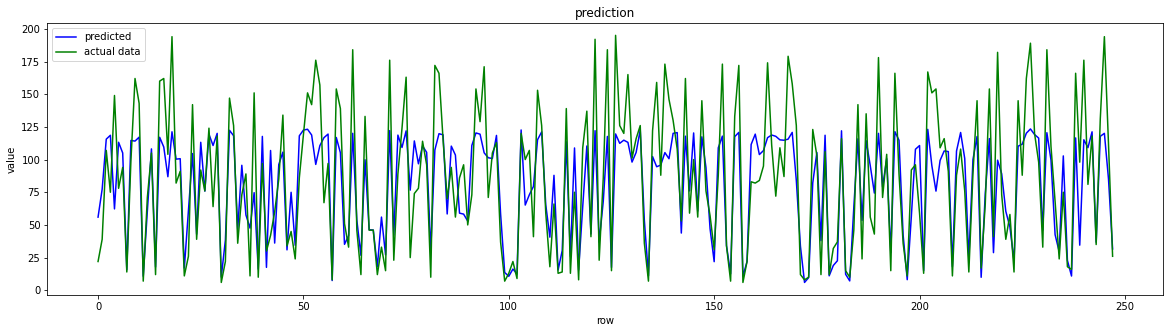

In [ ]:
# plot graph for RUL vs predictive RUL values for Testing data.
fig_verify = plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

By looking at RMSE, we come know that model giving good results.by applying deep learning techniques 

## Deep learning

### Data preprocessing

Split Test data into cross_validation and test data, we pick the last sequence data points as test data,remaining data points as cross_validation.

In [ ]:
x_train= Train 
# cross_val is other than last sequence data points (test data 13096 = cross_val(10096)+test(300))
x_cross = splite_data(50,Test,cross_val=True) 

# we have 248 engine data,# We pick the last sequence data points as test data 
x_test = splite_data(50,Test,cross_val= False) 

print('X_train : {}'.format(x_train.shape)) 
print('X_cross_val : {}'.format(x_cross.shape))  
print('X_test: {}'.format(x_test.shape)) 

X_train : (20631, 25)
X_cross_val : (8162, 25)
X_test: (4650, 25)


An LSTM and Conv1d model expects data to have the shape: [samples, timesteps, features]

we split the series with a fixed window and a sliding of 1 step. For example, engine 1 have 222 cycles in train, with a window length equal to 30 we extract 192 time series with length 50:

window1 -> from cycle0 to cycle 50,

window2 -> from cycle1 to cycle51, … ,

window192 -> from cycle172 to cycle222, window191.

Each window is labeled with the corresponding label of the final cycle taken into account by the window.

In [ ]:
sequence_length =50
def gen_sequence(id_df, seq_length, seq_cols):
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].clip(upper=125).values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [ ]:
label_gen_train = [gen_labels(x_train[x_train['Engine_No']==id],sequence_length,['RUL']) for id in x_train['Engine_No'].unique()]

train_label_array = np.concatenate(label_gen_train).astype(np.float32) 
train_label_array.shape  

(15631, 1)

In [ ]:
label_gen_cross = [gen_labels(x_cross[x_cross['Engine_No']==id], sequence_length,['RUL']) 
for id in x_cross['Engine_No'].unique() if len(x_cross[x_cross['Engine_No']==id])>= sequence_length]

cross_label_array = np.concatenate(label_gen_cross).astype(np.float32)
cross_label_array.shape 

(4097, 1)

In [ ]:
imp_col = ['T50','Nf','Ps30','phi','NRf','NRc','BPR','W31','W32','T48','T41','T90','Ve','EGT_margin','Nc/Nf','PCNcRdmd ','M_cold','W_f','Thrust','Fan_thrust','core_thrust','TSFC','Thermal_efficiency']

In [ ]:
### GENERATE X TRAIN TEST ### 
x_train_data, x_cross_data = [], []
for engine_id in x_train.Engine_No.unique():
    for sequence in gen_sequence(x_train[x_train['Engine_No']==engine_id], sequence_length, imp_col):
        x_train_data.append(sequence)
    for sequence in gen_sequence(x_cross[x_cross['Engine_No']==engine_id], sequence_length,imp_col):
        x_cross_data.append(sequence) 
seq_gen_train = np.asarray(x_train_data)
seq_array_cross= np.asarray(x_cross_data)

print("X_Train shape:", seq_gen_train.shape) 
print("X_cross shape:", seq_array_cross.shape)

X_Train shape: (15631, 50, 23)
X_cross shape: (4097, 50, 23)


In [ ]:
# We pick the last sequence for each engine id in the test data
seq_array_test_last = [x_test[x_test['Engine_No']==id][imp_col].values[-sequence_length:] 
                       for id in x_test['Engine_No'].unique() if len(x_test[x_test['Engine_No']==id])>= sequence_length] 

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(x_test[x_test['Engine_No']==id]) >= sequence_length for id in x_test['Engine_No'].unique()]
label_array_test_last = x_test.groupby('Engine_No')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(seq_array_test_last.shape)
print(label_array_test_last.shape) 

(93, 50, 23)
(93, 1)


In [ ]:
def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred - y_true))) 

### CNN model

In [ ]:
#np.random.seed(42)
# Model
model_cnn = Sequential() 
model_cnn.add(Conv1D(filters=32, kernel_size=2, activation='relu',input_shape=seq_gen_train.shape[1:])) 
model_cnn.add(BatchNormalization())
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(8, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.2)) 
model_cnn.add(Dense(1,activation='linear')) 
model_cnn.compile(loss='mae', optimizer='adam',metrics=[rmse])
model_cnn.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 49, 32)            1504      
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 32)            128       
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 12552     
_________________________________________________________________
batch_normalization_1 (Batch (None, 8)                 32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0

In [ ]:
checkpoint_callback = ModelCheckpoint('model_cnn_feaegg.h5', monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
# fit the network.
single_step_history = model_cnn.fit(seq_gen_train,train_label_array, epochs=30, batch_size=32, callbacks=[checkpoint_callback],validation_data=(seq_array_cross, cross_label_array),shuffle=True, verbose=2)

Epoch 1/30
489/489 - 3s - loss: 73.1778 - rmse: 83.5677 - val_loss: 107.7878 - val_rmse: 107.9174
Epoch 2/30
489/489 - 2s - loss: 63.4375 - rmse: 73.5656 - val_loss: 86.6000 - val_rmse: 86.9170
Epoch 3/30
489/489 - 2s - loss: 45.2214 - rmse: 53.8882 - val_loss: 58.0667 - val_rmse: 58.3680
Epoch 4/30
489/489 - 2s - loss: 24.5616 - rmse: 30.8896 - val_loss: 22.0464 - val_rmse: 23.0383
Epoch 5/30
489/489 - 2s - loss: 16.7444 - rmse: 21.6820 - val_loss: 15.7641 - val_rmse: 17.0690
Epoch 6/30
489/489 - 2s - loss: 16.0740 - rmse: 20.7034 - val_loss: 13.7102 - val_rmse: 14.9923
Epoch 7/30
489/489 - 2s - loss: 15.9973 - rmse: 20.5891 - val_loss: 10.9983 - val_rmse: 12.5221
Epoch 8/30
489/489 - 2s - loss: 15.7217 - rmse: 20.3465 - val_loss: 9.9014 - val_rmse: 11.3756
Epoch 9/30
489/489 - 2s - loss: 15.9953 - rmse: 20.6026 - val_loss: 15.9725 - val_rmse: 17.2507
Epoch 10/30
489/489 - 2s - loss: 15.8765 - rmse: 20.4428 - val_loss: 10.0219 - val_rmse: 11.4821
Epoch 11/30
489/489 - 2s - loss: 15.92

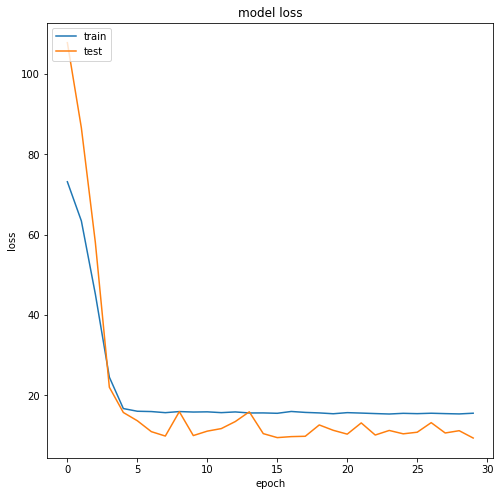

In [ ]:
# summarize for Loss
fig_acc = plt.figure(figsize=(8,8))
plt.plot(single_step_history.history['loss'])
plt.plot(single_step_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

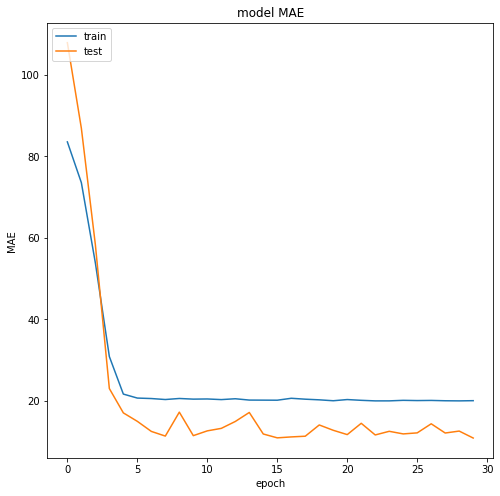

In [ ]:
fig_acc = plt.figure(figsize=(8,8))
plt.plot(single_step_history.history['rmse'])
plt.plot(single_step_history.history['val_rmse'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluation of training data
scores = model_cnn.evaluate(seq_gen_train, train_label_array, verbose=1, batch_size=32)
print('rmse: {}'.format(scores[1])) 

489/489 [==============================] - 1s 2ms/step - loss: 8.6430 - rmse: 9.7549
rmse: 9.754888534545898


In [ ]:
# Evaluation of cross val data
scores = model_cnn.evaluate(seq_array_cross, cross_label_array, verbose=1, batch_size=32)
print('rmse: {}'.format(scores[1])) 

129/129 [==============================] - 0s 2ms/step - loss: 9.4093 - rmse: 10.8964
rmse: 10.89641284942627


In [ ]:
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

3/3 - 0s - loss: 10.4782 - rmse: 14.5796
rmse: 14.579607963562012


In [ ]:
# test metrics
scores_test = model_cnn.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[0]))
y_pred_test = model_cnn.predict(seq_array_test_last)
y_true_test = label_array_test_last 
test_set = pd.DataFrame(y_pred_test)
submit = np.concatenate((y_true_test, y_pred_test), axis=1)
print(submit)

3/3 - 0s - loss: 10.4782 - rmse: 14.5796

MAE: 10.478177070617676
[[ 69.         58.385784 ]
 [ 82.         80.460045 ]
 [ 91.         91.57667  ]
 [ 93.        109.615906 ]
 [ 91.        106.82162  ]
 [ 95.         80.14138  ]
 [111.        112.665794 ]
 [ 96.         85.33296  ]
 [ 97.         85.086174 ]
 [124.         83.605576 ]
 [ 95.         80.09358  ]
 [ 83.        112.197235 ]
 [ 84.        102.29297  ]
 [ 50.         52.824203 ]
 [ 28.         33.37563  ]
 [ 87.         90.222404 ]
 [ 16.         13.986282 ]
 [ 57.         63.518253 ]
 [113.        117.8986   ]
 [ 20.         18.617609 ]
 [119.        118.45908  ]
 [ 66.         78.63298  ]
 [ 97.        101.84505  ]
 [ 90.         92.935524 ]
 [115.         79.345634 ]
 [  8.          6.2025185]
 [ 48.         45.059605 ]
 [106.        120.05628  ]
 [  7.         -2.3794813]
 [ 11.         10.816112 ]
 [ 19.         26.550142 ]
 [ 21.         25.662415 ]
 [ 50.         54.91247  ]
 [ 28.         26.325575 ]
 [ 18.         2

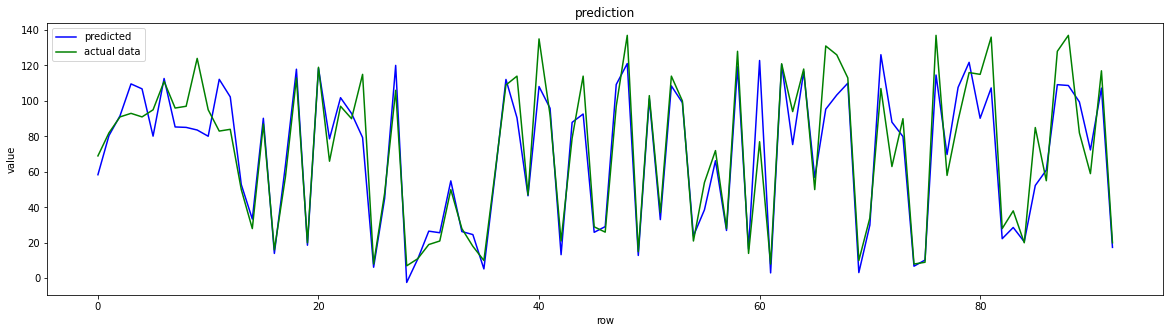

In [ ]:
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

### LSTM model

In [ ]:
nb_features = seq_gen_train.shape[2]
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=16,return_sequences=False,input_shape=(sequence_length, nb_features)))
model_LSTM.add(BatchNormalization())
model_LSTM.add(Dense(16, activation='relu'))
model_LSTM.add(BatchNormalization())
model_cnn.add(Dropout(0.2)) 
model_LSTM.add(Dense(1,activation='linear')) 
model_LSTM.compile(loss='mae', optimizer='adam',metrics=[rmse])
model_LSTM.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                2560      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 2,977
Trainable params: 2,913
Non-trainable params: 64
_________________________________________________________________


In [ ]:
checkpoint_callback = ModelCheckpoint('model_feaegg_LSTM.h5', monitor='val_rmse', save_best_only=True, mode='min', verbose=0)
# fit the network.
history = model_LSTM.fit(seq_gen_train,train_label_array, epochs=30, batch_size=32, callbacks=[checkpoint_callback],validation_data=(seq_array_cross, cross_label_array),shuffle=True, verbose=2) 

Epoch 1/30
489/489 - 4s - loss: 71.1189 - rmse: 81.1994 - val_loss: 96.7237 - val_rmse: 96.9467
Epoch 2/30
489/489 - 3s - loss: 50.7955 - rmse: 58.7534 - val_loss: 50.9894 - val_rmse: 51.7247
Epoch 3/30
489/489 - 3s - loss: 21.0605 - rmse: 26.2644 - val_loss: 15.0705 - val_rmse: 16.4783
Epoch 4/30
489/489 - 3s - loss: 11.2142 - rmse: 14.3694 - val_loss: 12.6797 - val_rmse: 14.1174
Epoch 5/30
489/489 - 3s - loss: 10.9779 - rmse: 14.1372 - val_loss: 22.3937 - val_rmse: 23.5888
Epoch 6/30
489/489 - 3s - loss: 10.7948 - rmse: 13.8996 - val_loss: 12.7146 - val_rmse: 14.2691
Epoch 7/30
489/489 - 3s - loss: 10.9053 - rmse: 14.0121 - val_loss: 9.0301 - val_rmse: 10.5022
Epoch 8/30
489/489 - 3s - loss: 10.5297 - rmse: 13.6342 - val_loss: 11.5553 - val_rmse: 13.0383
Epoch 9/30
489/489 - 3s - loss: 10.5722 - rmse: 13.7156 - val_loss: 10.8886 - val_rmse: 12.5491
Epoch 10/30
489/489 - 3s - loss: 10.5618 - rmse: 13.6610 - val_loss: 11.8550 - val_rmse: 13.4181
Epoch 11/30
489/489 - 3s - loss: 10.2769

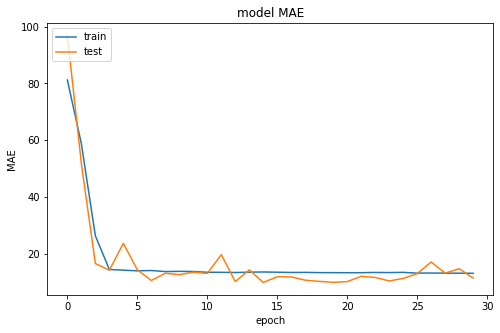

In [ ]:
fig_acc = plt.figure(figsize=(8, 5))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

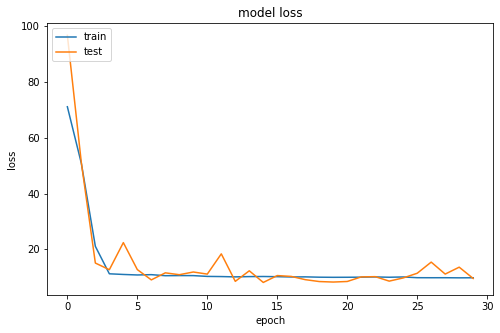

In [ ]:
# summarize for Loss
fig_acc = plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Evaluation of training data
scores = model_LSTM.evaluate(seq_gen_train, train_label_array, verbose=1, batch_size=64)
print('rmse: {}'.format(scores[1])) 

245/245 [==============================] - 1s 3ms/step - loss: 8.9558 - rmse: 10.7229
rmse: 10.722877502441406


In [ ]:
# Evaluation of cross val data
scores = model_LSTM.evaluate(seq_array_cross, cross_label_array, verbose=1, batch_size=64)
print('rmse: {}'.format(scores[1])) 

65/65 [==============================] - 0s 3ms/step - loss: 9.5400 - rmse: 11.8419
rmse: 11.841910362243652


In [ ]:
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

3/3 - 0s - loss: 12.0211 - rmse: 17.1527
rmse: 17.152658462524414


In [ ]:
# For training data, we will comparing ture RUL vs predictive values
y_pred = model_LSTM.predict(seq_gen_train,verbose=1, batch_size=64)
y_pred.shape
submit = np.dstack((y_pred, train_label_array))
print(submit)

245/245 [==============================] - 1s 3ms/step
[[[127.47984   125.       ]]

 [[127.542244  125.       ]]

 [[128.39769   125.       ]]

 ...

 [[  6.6530576   2.       ]]

 [[  6.1533847   1.       ]]

 [[  4.7340684   0.       ]]]


In [ ]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/10) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/13) - 1
    return tmp

In [ ]:
# test metrics
scores_test = model_LSTM.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
y_pred_test = model_LSTM.predict(seq_array_test_last)
y_true_test = label_array_test_last
test_set = pd.DataFrame(y_pred_test)
submit = np.concatenate((y_true_test, y_pred_test), axis=1)
print(submit)

3/3 - 0s - loss: 12.0211 - rmse: 17.1527

MAE: 17.152658462524414
[[ 69.         46.43835  ]
 [ 82.         65.12938  ]
 [ 91.         79.0099   ]
 [ 93.        106.610016 ]
 [ 91.        108.35555  ]
 [ 95.         63.24216  ]
 [111.        108.82413  ]
 [ 96.         76.37098  ]
 [ 97.         73.06122  ]
 [124.         71.86147  ]
 [ 95.         73.21014  ]
 [ 83.        117.78328  ]
 [ 84.         96.917595 ]
 [ 50.         45.2304   ]
 [ 28.         30.970772 ]
 [ 87.         78.19182  ]
 [ 16.         15.665512 ]
 [ 57.         49.90797  ]
 [113.        124.94241  ]
 [ 20.         16.913052 ]
 [119.        119.463715 ]
 [ 66.         75.18154  ]
 [ 97.         91.98739  ]
 [ 90.         86.95401  ]
 [115.         66.99548  ]
 [  8.         11.526138 ]
 [ 48.         40.56214  ]
 [106.        115.51686  ]
 [  7.          5.8572903]
 [ 11.         10.775194 ]
 [ 19.         28.008038 ]
 [ 21.         31.123884 ]
 [ 50.         46.030056 ]
 [ 28.         27.292095 ]
 [ 18.         2

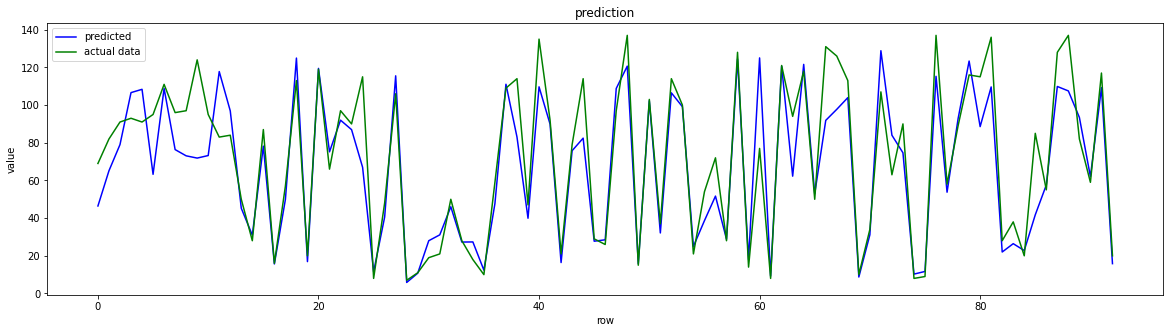

In [ ]:
# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()

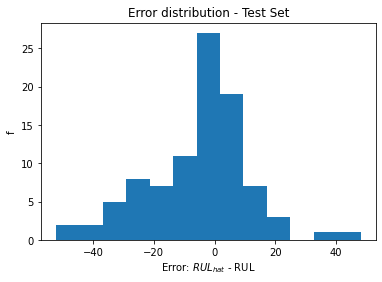

Score = 469.6714355405947


In [ ]:
d = y_pred_test - y_true_test
plt.hist(d, bins='auto')  
plt.title('Error distribution - Test Set')
plt.ylabel('f')
plt.xlabel("Error: $RUL_{hat}$ - RUL")
plt.show()
score_i_tr = score_cal(y_pred_test, y_true_test)
print("Score = " + str(sum(score_i_tr)))

## Results

### CNN

In [ ]:
model_cnn = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD001/model_cnn_feaegg.h5',custom_objects={'loss':rmse},compile=False)
model_cnn.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

3/3 - 0s - loss: 11.1666 - rmse: 14.4947
rmse: 14.4946928024292


In [ ]:
model_cnn = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD002/model_cnn_feaegg.h5',custom_objects={'loss':rmse},compile=False)
model_cnn.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

8/8 - 0s - loss: 18.7575 - rmse: 26.2711
rmse: 26.271089553833008


In [ ]:
model_cnn = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD003/model_cnn_feaegg.h5',custom_objects={'loss':rmse},compile=False)
model_cnn.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

4/4 - 0s - loss: 11.3417 - rmse: 12.5407
rmse: 12.540700912475586


In [ ]:
model_cnn = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD004/model_cnn_feaegg.h5',custom_objects={'loss':rmse},compile=False)
model_cnn.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_cnn.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

8/8 - 0s - loss: 19.4764 - rmse: 25.5273
rmse: 25.52730941772461


### LSTM

In [ ]:
model_LSTM = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD001/model_feaegg_LSTM.h5',custom_objects={'loss':rmse},compile=False)
model_LSTM.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

3/3 - 0s - loss: 10.7765 - rmse: 14.8704
rmse: 14.870388984680176


In [ ]:
model_LSTM = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD002/model_feaegg_LSTM.h5',custom_objects={'loss':rmse},compile=False)
model_LSTM.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

8/8 - 0s - loss: 18.0730 - rmse: 25.1818
rmse: 25.18179702758789


In [ ]:
model_LSTM = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD003/model_feaegg_LSTM.h5',custom_objects={'loss':rmse},compile=False)
model_LSTM.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

4/4 - 0s - loss: 9.9130 - rmse: 10.6389
rmse: 10.638896942138672


In [ ]:
model_LSTM = load_model('/content/drive/My Drive/Self Case Study 1/data/output/FD004/model_feaegg_LSTM.h5',custom_objects={'loss':rmse},compile=False)
model_LSTM.compile(loss='mae', optimizer='adam',metrics=[rmse])
# Evaluation of Test data data 
scores_test = model_LSTM.evaluate(seq_array_test_last,label_array_test_last, verbose=2)
print('rmse: {}'.format(scores_test[1]))

8/8 - 0s - loss: 19.2176 - rmse: 24.5067
rmse: 24.50673484802246


### RF

In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD001/RF_model_RUL.pkl', 'rb'))
y_hat_cross = loaded_model.predict(x_cross_val)
evaluate(y_cross_val_clipped, y_hat_cross) 

test set RMSE:17.563652346831063, R2:0.585872354726764


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD002/RF_model_RUL.pkl', 'rb'))
y_hat_cross = loaded_model.predict(x_cross_val)
evaluate(y_cross_val_clipped, y_hat_cross) 

test set RMSE:18.938457252898537, R2:0.5595060837220247


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD003/RF_model_RUL.pkl', 'rb'))
y_hat_cross = loaded_model.predict(x_cross_val)
evaluate(y_cross_val_clipped, y_hat_cross) 

test set RMSE:15.203627435784782, R2:0.6161865937268103


In [ ]:
loaded_model = load(open('/content/drive/My Drive/Self Case Study 1/data/output/FD004/RF_model_RUL.pkl', 'rb'))
y_hat_cross = loaded_model.predict(x_cross_val)
evaluate(y_cross_val_clipped, y_hat_cross) 

test set RMSE:16.683685498529744, R2:0.560829406336161


## Prettytable

In [ ]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable    
x = PrettyTable() 
x.field_names = ["Model","FD001","FD002", "FD003", "FD004"] 
x.add_row(['Baseline model(liner)','21.48046059777049','32.641518113498655','22.997076704589805','36.39553049622252'])
x.add_row(['Random forest regressor','18.47346864729759','29.608658630267694','21.260854026503893','31.424181616544033'])
x.add_row(['CNN',"14.4946928024292","26.271089553833008","12.540700912475586",'25.52730941772461'])  
x.add_row(['LSTM','14.870388984680176','25.18179702758789','10.638896942138672','24.50673484802246']) 
print(x) 

+-------------------------+--------------------+--------------------+--------------------+--------------------+
|          Model          |       FD001        |       FD002        |       FD003        |       FD004        |
+-------------------------+--------------------+--------------------+--------------------+--------------------+
|  Baseline model(liner)  | 21.48046059777049  | 32.641518113498655 | 22.997076704589805 | 36.39553049622252  |
| Random forest regressor | 18.47346864729759  | 29.608658630267694 | 21.260854026503893 | 31.424181616544033 |
|           CNN           |  14.4946928024292  | 26.271089553833008 | 12.540700912475586 | 25.52730941772461  |
|           LSTM          | 14.870388984680176 | 25.18179702758789  | 10.638896942138672 | 24.50673484802246  |
+-------------------------+--------------------+--------------------+--------------------+--------------------+


 RMSE which is a decent improvement over our baseline, but doesn’t come close to the deep learing models

## Hypertuning

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78937 sha256=099cfefa918dca479d4e7e7843356ecf4efb6e84e2b2343189ffe72c5108ec48
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=f21436671e9563d2a89c3d65a9f5e0c118b0d934d0ca40cb65f77ebe6937380e
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [ ]:
nb_features = seq_gen_train.shape[2]
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.Sequential()
    model.add(Conv1D(hp.Int('input_units',min_value=32,max_value=512,step=32),2, activation='relu',input_shape=(sequence_length, nb_features)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(rate=hp.Float('dropout_1',min_value=0.0,max_value=0.8,step=0.1))) 
    model.add(Dense(units=hp.Int('units_1',min_value=8,max_value=512,step=8),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2',min_value=0.0,max_value=0.8,step=0.1)))
    model.add(Dense(units=hp.Int('units_2',min_value=8,max_value=512,step=8),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3',min_value=0.0,max_value=0.8,step=0.1)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),loss='mae',metrics=[rmse])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=5,
    directory='project',
    project_name='CNN_tuner')

INFO:tensorflow:Reloading Oracle from existing project project/CNN_tuner/oracle.json
INFO:tensorflow:Reloading Tuner from project/CNN_tuner/tuner0.json


In [ ]:
tuner.search(seq_gen_train,train_label_array, epochs=30, batch_size=32, validation_data=(seq_array_cross, cross_label_array),verbose=1)


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
input_units       |256               |32                
dropout_1         |0.6               |0.1               
units_1           |296               |408               
dropout_2         |0.6               |0.8               
units_2           |304               |192               
dropout_3         |0.1               |0.3               
learning_rate     |0.001             |0.001             

Epoch 1/30
1525/1525 [==============================] - 9s 6ms/step - loss: 30.8358 - rmse: 38.0040 - val_loss: 10.8637 - val_rmse: 12.2887
Epoch 2/30
 485/1525 [========>.....................] - ETA: 4s - loss: 18.6476 - rmse: 25.5406

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
tuner.get_best_models()[0].summary()

In [ ]:
best_model= tuner.get_best_models()[0]

In [ ]:
# test metrics
scores_test = best_model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('\nMAE: {}'.format(scores_test[1]))
y_pred_test = best_model.predict(seq_array_test_last)
y_true_test = label_array_test_last
test_set = pd.DataFrame(y_pred_test)
submit = np.concatenate((y_true_test, y_pred_test), axis=1)
print(submit)

In [ ]:
# actual data to verify visually the accuracy of the model.
fig_verify = plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color="blue")
plt.plot(y_true_test, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()